In [129]:
import sys
from pathlib import Path

from tqdm import tqdm
import toml

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

from utils import norm, unnorm, criterion
from dataset_utils import create_dataset
from models import load_model
import time

# Configure Script
config = toml.load(f'configs/imagenet/query/audioclip.toml')['general']
epochs = config['epochs']
gpu_num = config['gpu_num']
batch_size = config['batch_size']
eps = config['epsilon']
seed = config['seed']
output_dir = config['output_dir']
n_images = config['number_images']
buffer_size = config['buffer_size']
delta = config['delta']
model_flag = config.get('model_flag', 'imagebind')
embs_input = config.get('embeddings_input', output_dir + 'embs.npy')\
                   .format(model_flag)
modality = config.get('modality', 'vision')
dataset_flag = config.get('dataset_flag', 'imagenet')
input_images_file = config.get('input_images_file', None)

if modality == 'vision':
    eps = eps / 255
    
Path(output_dir).mkdir(parents=True, exist_ok=True)

full_flag=False
if "full" in output_dir:
    full_flag = True

print('Full_flag: ',full_flag)

hybrid=False
if input_images_file!=None:
    hybrid=True
print('Hybrid: ',hybrid)

device = f"cuda:{gpu_num}" if torch.cuda.is_available() else "cpu"
assert n_images % batch_size == 0

# Instantiate Model
model = load_model(model_flag, device)

# Load Data
image_text_dataset = create_dataset(dataset_flag, model=model, device=device, seed=seed, embs_input=embs_input)
# Create Adversarial Examples
X_advs = []
X_inits = []
gts = []
gt_loss = []
adv_loss = []
end_iter = []

# TODO: verify added code
y_ids = []
y_origs = []

final = []

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
    
def get_loss(y, logits, targeted=False, loss_type='margin_loss'):
    """ Implements the margin loss (difference between the correct and 2nd best class). """
    if loss_type == 'margin_loss':
        preds_correct_class = (logits * y).sum(1, keepdims=True)
        diff = preds_correct_class - logits  # difference between the correct class and all other classes
        diff[y] = np.inf  # to exclude zeros coming from f_correct - f_correct
        margin = diff.min(1, keepdims=True)
        loss = margin * -1 if targeted else margin
        # print(loss)
    elif loss_type == 'cross_entropy':
        probs = softmax(logits)
        # print(y)
        # print(probs.shape)
        loss = -np.log(probs[y])
        loss = loss * -1 if not targeted else loss
    return loss.flatten()
    
def dense_to_onehot(y_test, n_cls):
    y_test_onehot = np.zeros([len(y_test), n_cls], dtype=bool)
    y_test_onehot[np.arange(len(y_test)), y_test] = True
    return y_test_onehot

def p_selection(p_init, it, n_iters):
    """ Piece-wise constant schedule for p (the fraction of pixels changed on every iteration). """
    it = int(it / n_iters * 10000)

    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init

    return p

def square_attack_linf(model, x, y, eps, n_iters, p_init, metrics_path, targeted, loss_type, local_adv=None):
    """ The Linf square attack """
    np.random.seed(0)  # important to leave it here as well
    early_break=False
    x=unnorm(x).to(device)
    min_val, max_val = 0, 1
    c, h, w = x.shape[1:]
    n_features = c*h*w
    n_ex_total = x.shape[0]

    if local_adv==None:
        init_delta = torch.tensor(np.random.choice([-eps, eps], size=[x.shape[0], c, 1, w])).to(torch.float).to(device)
    else:
        local_adv=unnorm(local_adv).to(device)
        init_delta = local_adv-x
    # init_delta=0
    x_best = torch.clip(x + init_delta, min_val, max_val)
    with torch.no_grad():
        embeds = model.forward(x_best.cuda(), modality, normalize=True)
    logits=criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].cpu(), dim=2).detach().cpu().numpy()
    loss_min = get_loss(y, logits, targeted, loss_type=loss_type)
    margin_min = get_loss(y, logits, targeted, loss_type='margin_loss')
    n_queries = np.ones(x.shape[0])  # ones because we have already used 1 query

    time_start = time.time()
    metrics = np.zeros([n_iters, 7])
    for i_iter in range(n_iters - 1):
        idx_to_fool = margin_min > 0
        x_curr, x_best_curr, y_curr = x[idx_to_fool], x_best[idx_to_fool], y[idx_to_fool]
        loss_min_curr, margin_min_curr = loss_min[idx_to_fool], margin_min[idx_to_fool]
        deltas = x_best_curr - x_curr
        p = p_selection(p_init, i_iter, n_iters)
        for i_img in range(x_best_curr.shape[0]):
            s = int(round(np.sqrt(p * n_features / c)))
            s = min(max(s, 1), h-1)  # at least c x 1 x 1 window is taken and at most c x h-1 x h-1
            center_h = np.random.randint(0, h - s)
            center_w = np.random.randint(0, w - s)

            x_curr_window = x_curr[i_img, :, center_h:center_h+s, center_w:center_w+s]
            x_best_curr_window = x_best_curr[i_img, :, center_h:center_h+s, center_w:center_w+s]
            # prevent trying out a delta if it doesn't change x_curr (e.g. an overlapping patch)
            while torch.sum(torch.abs(torch.clip(x_curr_window + deltas[i_img, :, center_h:center_h+s, center_w:center_w+s], min_val, max_val) - x_best_curr_window) < 10**-7) == c*s*s:
                deltas[i_img, :, center_h:center_h+s, center_w:center_w+s] = torch.tensor(np.random.choice([-eps, eps], size=[c, 1, 1]))

        x_new = torch.clip(x_curr + deltas, min_val, max_val).to(device)
        with torch.no_grad():
            embeds = model.forward(x_new, modality, normalize=True)
        logits=criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].cpu(), dim=2).detach().cpu().numpy()
        loss = get_loss(y_curr, logits, targeted, loss_type=loss_type)
        margin = get_loss(y_curr, logits, targeted, loss_type='margin_loss')

        
        idx_improved = loss < loss_min_curr
        loss_min[idx_to_fool] = idx_improved * loss + ~idx_improved * loss_min_curr
        margin_min[idx_to_fool] = idx_improved * margin + ~idx_improved * margin_min_curr
        idx_improved = torch.tensor(np.reshape(idx_improved, [-1, *[1]*len(x.shape[:-1])])).to(device)
        x_best[idx_to_fool] = idx_improved * x_new + ~idx_improved * x_best_curr
        n_queries[idx_to_fool] += 1
        acc = (margin_min > 0.0).sum() / n_ex_total
        acc_corr = (margin_min > 0.0).mean()
        mean_nq, mean_nq_ae, median_nq_ae = np.mean(n_queries), np.mean(n_queries[margin_min <= 0]), np.median(n_queries[margin_min <= 0])
        avg_margin_min = np.mean(margin_min)
        time_total = time.time() - time_start
        if i_iter%10==0:
            print('{}: acc={:.2%} acc_corr={:.2%} avg#q_ae={:.2f} med#q={:.1f}, avg_margin={:.6f} (n_ex={}, eps={:.3f}, {:.2f}s)'.
                format(i_iter+1, acc, acc_corr, mean_nq_ae, median_nq_ae, avg_margin_min, x.shape[0], eps, time_total))

        metrics[i_iter] = [acc, acc_corr, mean_nq, mean_nq_ae, median_nq_ae, margin_min.mean(), time_total]
            
        if i_iter>10000 and (metrics[i_iter-10000][5]-metrics[i_iter][5]<0.001):
            early_break=True
        if (i_iter <= 500 and i_iter % 20 == 0) or (i_iter > 100 and i_iter % 50 == 0) or i_iter + 1 == n_iters or acc == 0 or early_break==True:
            np.save(metrics_path, metrics)

        if full_flag==False:
            if acc == 0 or early_break==True:
                break
        else:
            if early_break==True:
                break

    return n_queries, x_best

targeted=True  
p=0.05
if targeted:
    p=0.01
loss='cross_entropy'
torch.manual_seed(seed)
if hybrid==True:
    local_advs_path = input_images_file
    local_advs = np.load(local_advs_path)
    local_advs=torch.tensor(local_advs).to(device)

    success=0
    n=0
    dataloader = DataLoader(image_text_dataset, batch_size=1, shuffle=True)
    for i, (X, Y, gt, y_id, y_orig) in enumerate(dataloader):
        if n==100:
            break
        embeds = model.forward(local_advs[i].unsqueeze(0), modality, normalize=False)
        classes = criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].cpu(), dim=2).argsort(dim=1, descending=True)
        if torch.all((classes == y_id[:, None]).nonzero(as_tuple=True)[1].cpu() == 0):
            success+=1
        n+=1
    print("the attack success rate is "+ str(success)+ "%")
    print("-----------------------------------------")

torch.manual_seed(seed)
dataloader = DataLoader(image_text_dataset, batch_size=batch_size, shuffle=True)

epochs=200
eps=0.2
for i, (X, Y, gt, y_id, y_orig) in enumerate(dataloader):
    print(i)
    metrics_path = f"{output_dir}metrics_{i}.npy"
    if targeted:
        y=dense_to_onehot(y_id, n_cls=1000)
    else:
        y=dense_to_onehot(y_orig, n_cls=1000)

    if hybrid==True:
        local_adv=local_advs[i*batch_size:i*batch_size+batch_size]
        n_queries, x_adv = square_attack_linf(model, X, y, eps, epochs,
                                        p, metrics_path, targeted, loss, local_adv)
    else:
        n_queries, x_adv = square_attack_linf(model, X, y, eps, epochs,
                                        p, metrics_path, targeted, loss)
        print("hello")
    if i == (n_images // batch_size)-1:
        break     

Full_flag:  False
Hybrid:  False


0


/home/tz362/anaconda3/envs/adversarial_illusions/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tz362/anaconda3/envs/adversarial_illusions/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.054360 (n_ex=100, eps=0.200, 1.11s)
11: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.050448 (n_ex=100, eps=0.200, 10.21s)
21: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.048289 (n_ex=100, eps=0.200, 18.00s)
31: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.046855 (n_ex=100, eps=0.200, 25.96s)
41: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.045807 (n_ex=100, eps=0.200, 34.26s)
51: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.044998 (n_ex=100, eps=0.200, 42.15s)
61: acc=100.00% acc_corr=100.00% avg#q_ae=nan med#q=nan, avg_margin=0.044252 (n_ex=100, eps=0.200, 50.07s)
71: acc=99.00% acc_corr=99.00% avg#q_ae=65.00 med#q=65.0, avg_margin=0.043311 (n_ex=100, eps=0.200, 57.99s)
81: acc=99.00% acc_corr=99.00% avg#q_ae=65.00 med#q=65.0, avg_margin=0.042579 (n_ex=100, eps=0.200, 65.90s)
91: acc=97.00% acc_corr=97.00% avg#q_

In [99]:
x_adv.max()

tensor(1., device='cuda:0')

In [130]:
with torch.no_grad():
    embeds = model.forward(x_adv.cuda(), modality, normalize=True)
logits=criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].cpu(), dim=2).detach().cpu().numpy()
y=dense_to_onehot(y_id, n_cls=1000)
loss_min = get_loss(y, logits, targeted, loss_type='margin_loss')
print(loss_min)

[ 5.2476093e-02  4.6614997e-02  2.8729059e-02  2.3661539e-02
  5.1735617e-02  6.3388646e-03  3.8967341e-02  7.3311150e-02
  4.0327907e-02  5.1663287e-02  3.9816685e-02  6.1535373e-02
  9.6707731e-02  8.9847066e-02  3.7414126e-02  2.8764695e-02
  3.2306463e-02  3.4426622e-02  3.3751294e-02  5.5192560e-02
  2.9054850e-02  4.5852602e-02  2.3076944e-02  2.2100441e-02
 -7.5280666e-05 -1.8529445e-03  7.2642505e-02  3.9194673e-02
  5.3144172e-02  3.7311688e-02 -1.1713803e-04  5.6080401e-02
  2.7888268e-02  4.8436940e-02  1.9845866e-02  6.1349541e-02
  2.0319045e-02  6.2346578e-02  7.2362117e-02  2.4151310e-02
  2.7167171e-02  2.3229763e-02  2.4847731e-02  1.8927559e-02
  6.3375227e-02  5.8992453e-02  2.3177497e-02  4.6531774e-02
  1.8036395e-02  3.9915495e-02  5.2302271e-02  2.2532970e-02
  3.4577325e-02  6.1538562e-02  2.7004570e-02  2.7159236e-02
  4.1637026e-02  5.4486990e-02  3.4177735e-02  5.8283828e-02
  4.9331561e-02  4.0892899e-02  2.7880102e-02  5.6058139e-02
  5.8000036e-02  5.82136

In [131]:
with torch.no_grad():
    embeds = model.forward(x_adv.to(device), modality, normalize=True).detach().cpu()
    classes = criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].detach().cpu(), dim=2).argsort(dim=1, descending=True)
print((classes == y_id[:, None])[:, 0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])


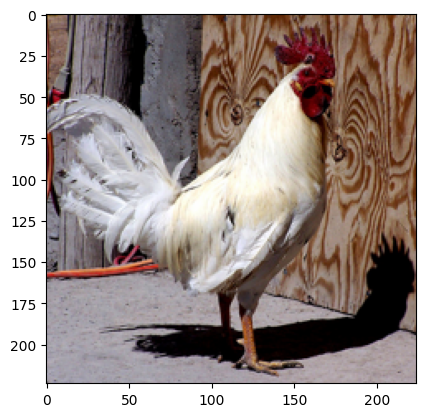

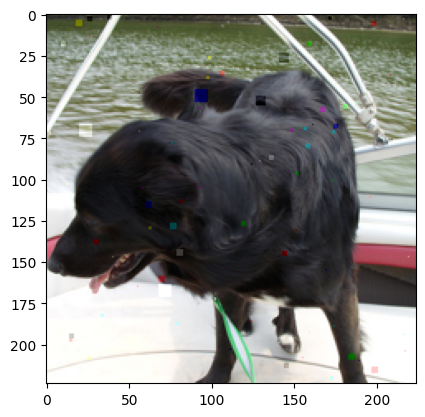

In [103]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
transform = transforms.ToPILImage()
plt.imshow(transform(torch.squeeze(unnorm(gt)[0])))
plt.show()
plt.imshow(transform(torch.squeeze(x_adv[0])))
plt.show()

In [51]:
(x_adv.cuda()-).max()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [84]:
gtunnorm=unnorm(gt.cuda())

In [85]:
(x_adv-gtunnorm.cuda()).min()

tensor(-1., device='cuda:0')

In [65]:
x_adv.max()

tensor(1., device='cuda:0')

In [46]:
with torch.no_grad():
    embeds = model.forward(gt.to(device), modality, normalize=False).detach().cpu()
    classes = criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].detach().cpu(), dim=2).argsort(dim=1, descending=True)
print((classes == y_id[:, None])[:, 0])


tensor([ True, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False, False, False,  True, False,  True,
        False, False,  True, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
         True, False,  True, False,  True,  True, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False])


In [14]:
margin_min

NameError: name 'margin_min' is not defined

In [12]:
y_id

tensor([695, 463, 482, 892, 627, 826, 321, 928, 780, 111, 912, 408,  29, 770,
        779, 838, 430, 891, 624, 983, 844, 614, 985, 501, 479,  21, 485, 163,
        987, 270, 212, 992, 770, 236, 374, 293, 554, 869, 975, 297, 102, 892,
        124, 636, 288, 822, 471, 662, 138, 901, 864, 705, 698, 341, 996, 584,
        204, 731, 801, 538, 441, 211, 652,  56,  90, 697, 769, 594, 323, 638,
        464, 190, 133, 677, 790, 115, 456, 535, 714, 712, 620, 219, 102, 206,
        809, 191, 655, 750, 636, 797, 614, 669, 329, 141,  92, 124, 529,  34,
        912, 929])

In [5]:
y_orig

tensor([ 13, 749, 905, 395, 446, 469, 976, 496, 598, 789, 686, 995, 903, 671,
         69,  80,  64, 372, 113, 284, 140, 236,  14, 421,  55, 848, 402, 515,
        382, 505, 406, 114, 483, 537, 499, 231, 362, 322,  27, 539, 863, 205,
         48,  66, 278, 828,  88, 676, 163, 585, 324, 484, 241, 161, 562, 665,
         58, 222, 814, 720, 105, 191, 838,  22, 621, 956, 639, 723,  24, 495,
        552, 662, 952,  44, 539,  30, 143, 996, 197, 753, 754, 654, 567,  82,
        544, 788, 810, 408, 874, 628, 551, 235, 633, 104, 400, 315, 880, 482,
        709, 607])

In [78]:
# Record batchwise information
for i, (X, Y, gt, y_id, y_orig) in enumerate(dataloader):
    embeds = model.forward(gt.to(device), modality, normalize=False).detach().cpu()
    classes = criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].detach().cpu(), dim=2).argsort(dim=1, descending=True)
    print((classes == y_id[:, None])[:, 0].sum())
    break


tensor(28)


In [80]:
with torch.no_grad():
    embeds = model.forward(x_adv.cuda(), modality, normalize=False)
logits=criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].cpu(), dim=2).detach().cpu().numpy()
y=dense_to_onehot(y_id, n_cls=1000)
loss_min = get_loss(y, logits, targeted, loss_type='margin_loss')
print(loss_min)

[ 0.07493129  0.1314202   0.08525458  0.05117958  0.03126916  0.05936913
  0.10403705  0.0694491   0.05986803  0.13493243  0.02867913  0.05832392
  0.06850505  0.04527347  0.09129559  0.08138484  0.06653757  0.09841686
  0.10430191  0.04885809  0.06095971  0.10890447  0.12956221  0.03774577
  0.08880015  0.04433729  0.06565589  0.10920963  0.06082398  0.13301173
  0.11989546  0.07686456  0.08005208  0.06680104  0.11889251  0.07914477
  0.0665679   0.0695906   0.10936965  0.04470373  0.10786339  0.06685554
  0.13609163  0.06274563  0.09159132  0.10128124  0.09087545  0.10072849
  0.11282427  0.0568784   0.11354223  0.03571965  0.08225156  0.04927346
  0.08440258  0.1099604   0.08898215  0.10033192  0.11474963  0.02727906
  0.13858977  0.05124469  0.04933655  0.05761724  0.1343602   0.0642444
  0.05583629  0.06512937  0.13396487  0.09149323  0.1115341   0.08739167
  0.08543233  0.08249116  0.05366906  0.12224474  0.07626897  0.06721718
  0.1291735  -0.04046385  0.07212885  0.05720332  0.

In [ ]:
def get_loss(y, logits, targeted=False, loss_type='margin_loss'):
    """ Implements the margin loss (difference between the correct and 2nd best class). """
    if loss_type == 'margin_loss':
        preds_correct_class = (logits * y).sum(1, keepdims=True)
        diff = preds_correct_class - logits  # difference between the correct class and all other classes
        diff[y] = np.inf  # to exclude zeros coming from f_correct - f_correct
        margin = diff.min(1, keepdims=True)
        loss = margin * -1 if targeted else margin
        # print(loss)
    elif loss_type == 'cross_entropy':
        probs = softmax(logits)
        # print(y)
        # print(probs.shape)
        loss = -np.log(probs[y])
        loss = loss * -1 if not targeted else loss
    return loss.flatten()

In [36]:
loss_min

array([0.09714048, 0.12487489, 0.05144023, 0.06768523, 0.04026401,
       0.05886733, 0.0657456 , 0.08740498, 0.09870418, 0.06454486,
       0.13596135, 0.09166092, 0.08199668, 0.07626347, 0.12346395,
       0.11836249, 0.05073092, 0.04086912, 0.09929728, 0.03018703,
       0.11900447, 0.07683112, 0.06567794, 0.11235766, 0.0800146 ,
       0.08098242, 0.11556449, 0.05329479, 0.06148025, 0.11354709,
       0.0416915 , 0.12500267, 0.12292268, 0.07080469, 0.10995544,
       0.05958908, 0.07506498, 0.11553796, 0.1051964 , 0.12613049,
       0.08146922, 0.05232919, 0.10110374, 0.08043491, 0.07486767,
       0.12028798, 0.0923178 , 0.12670857, 0.07578788, 0.1374691 ,
       0.06680165, 0.06199922, 0.09724347, 0.05856365, 0.07354952,
       0.042849  , 0.12492005, 0.06264535, 0.08472344, 0.08911232,
       0.04561106, 0.05086621, 0.12941568, 0.09695572, 0.09491241,
       0.14375575, 0.09325572, 0.11540885, 0.02872503, 0.12758753,
       0.13481228, 0.09706341, 0.10600758, 0.0688462 , 0.13350

In [128]:
# Record batchwise information
with torch.no_grad():
    norm_x_adv=norm(x_adv)
    gt_embeddings = model.forward(norm_x_adv.to(device), modality, normalize=True).detach().cpu()
    embeds = model.forward(x_adv.to(device), modality, normalize=True).detach().cpu()
    classes = criterion(embeds[:, None, :].cpu(), image_text_dataset.labels[None, :, :].detach().cpu(), dim=2).argsort(dim=1, descending=True)
gt_loss = []

X_advs.append(norm_x_adv.detach().cpu().clone())
X_inits.append(X.cpu().clone())
gts.append(gt.cpu().clone())
gt_loss.append(criterion(gt_embeddings, Y.cpu(), dim=1))
adv_loss.append(criterion(embeds.detach().cpu(), Y.cpu(), dim=1))
end_iter.append(n_queries)
print((classes == y_id[:, None])[:, 0])
y_ids.append(y_id.cpu())
y_origs.append(y_orig.cpu())
final.append((classes == y_id[:, None])[:, 0].cpu())

np.save(output_dir + 'x_advs', np.concatenate(X_advs))
np.save(output_dir + 'x_inits', np.concatenate(X_inits))
np.save(output_dir + 'gts', np.concatenate(gts))
np.save(output_dir + 'gt_loss', np.concatenate(gt_loss))
np.save(output_dir + 'adv_loss', np.concatenate(adv_loss))
np.save(output_dir + 'end_iter', np.concatenate(end_iter))

np.save(output_dir + 'y_ids', np.concatenate(y_ids))
np.save(output_dir + 'y_origs', np.concatenate(y_origs))
np.save(output_dir + 'final', np.concatenate(final))

# Compute and print the average and standard deviation of gt_loss and adv_loss
gt_loss_avg = np.mean(np.concatenate(gt_loss))
gt_loss_std = np.std(np.concatenate(gt_loss))
adv_loss_avg = np.mean(np.concatenate(gt_loss))
adv_loss_std = np.std(np.concatenate(gt_loss))

print("Average organic alignment:", gt_loss_avg)
print("Standard deviation of organic alignment:", gt_loss_std)
print("Average adversarial alignment:", adv_loss_avg)
print("Standard deviation of adversarial alignment:", adv_loss_std)


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
Average organic alignment: 0.082408264
Standard deviation of organic alignment: 0.032215286
Average adversarial alignment: 0.082408264
Standard deviation of adversarial alignment: 0.032215286


In [127]:
# Compute and print the average and standard deviation of gt_loss and adv_loss
gt_loss_avg = np.mean(np.concatenate(gt_loss))
gt_loss_std = np.std(np.concatenate(gt_loss))
adv_loss_avg = np.mean(np.concatenate(gt_loss))
adv_loss_std = np.std(np.concatenate(gt_loss))

print("Average organic alignment:", gt_loss_avg)
print("Standard deviation of organic alignment:", gt_loss_std)
print("Average adversarial alignment:", adv_loss_avg)
print("Standard deviation of adversarial alignment:", adv_loss_std)

Average organic alignment: 0.10195634
Standard deviation of organic alignment: 0.028526453
Average adversarial alignment: 0.10195634
Standard deviation of adversarial alignment: 0.028526453


In [112]:
criterion(gt_embeddings[:, None, :].cpu(), Y.cpu(), dim=1)

tensor([[ 0.6233, -0.0458,  0.5642,  ..., -0.0337,  0.7881,  0.3248],
        [-0.6233, -0.0458,  0.5642,  ..., -0.0337,  0.7881,  0.3248],
        [-0.6233, -0.0458,  0.5642,  ..., -0.0337,  0.7881,  0.3248],
        ...,
        [-0.6233,  0.0458, -0.5642,  ..., -0.0337, -0.7881,  0.3248],
        [-0.6233, -0.0458, -0.5642,  ..., -0.0337,  0.7881, -0.3248],
        [ 0.6233, -0.0458, -0.5642,  ..., -0.0337,  0.7881, -0.3248]])

In [118]:
len(gt_loss)

4